In [61]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

In [62]:
# --- USER CONFIGURATION ---
# paths to your data
WIND_CSV        = "GML/data/wind_power_sdwpf.csv"         # rows: timestamp, cols: turbine IDs, values: wind direction in degrees
POS_CSV         = "GML/data/turbine_location.csv" # cols: ['turbine_id','x','y']
OUTPUT_TIMESTAMP = 4                       # which window index to plot in detail
N_CLUSTERS      = 3                        # how many K‐means clusters on the unit circle
WINDOW_SIZE     = 10                       # how many timestamps per batch
DIRECTION_TOL   = 20                       # degrees tolerance for building edges
MAX_NEIGHBORS   = 1                        # keep only the nearest downstream neighbor
MAX_WINDOWS    = 10                      # how many windows to process
# ----------------------------

In [63]:
# 1. – Load data
wind_df     = pd.read_csv(WIND_CSV,  index_col=0, parse_dates=True)
pos_df      = pd.read_csv(POS_CSV)


C:\Users\daank\AppData\Local\Temp\ipykernel_75556\2120534652.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wind_df     = pd.read_csv(WIND_CSV,  index_col=0, parse_dates=True)


In [88]:
from calendar import monthrange

# if Day is a day‐count or date and Tmstamp a time-of-day string,
# first build a true datetime index. Adjust the formatting as needed.
# Add a year and month (e.g., "2020-01-") to the date string for parsing
# Create a Datetime column, rolling over days for all months (assuming 2020, non-leap year)

def day_to_date(row):
    day = int(row["Day"])
    month = 1
    year = 2020
    while True:
        days_in_month = monthrange(year, month)[1]
        if day <= days_in_month:
            break
        day -= days_in_month
        month += 1
        if month > 12:
            year += 1
            month = 1
    return f"{year}-{str(month).zfill(2)}-{str(day).zfill(2)} {row['Tmstamp']}"

wind_df["Datetime"] = pd.to_datetime(
    wind_df.apply(day_to_date, axis=1),
    format="%Y-%m-%d %H:%M",
    errors="coerce"
)

# pivot to wide: rows=Datetime, cols=TurbID, vals=AbsWdir
# First, reset index so 'TurbID' is a column
wind_df_reset = wind_df.reset_index()

wind_wide = wind_df_reset.pivot(
    index="Datetime",
    columns="TurbID",
    values="AbsWdir"
).sort_index()

# now overwrite for convenience
wind_df = wind_wide


In [89]:
def normalize_angle(angle):
    """
    Brings any angle in degrees back to [0, 360).
    """
    return angle % 360

In [90]:
def compute_absolute_wind_direction(df):
    """
    Calculate absolute wind direction in degrees relative to true north (0-360°).
    """
    # Handle possible NaN values:
    df = df.copy()
    df['Wdir'] = df['Wdir'].fillna(0)
    df['Ndir'] = df['Ndir'].fillna(0)
    
    # Step 1: add Ndir and Wdir
    df['AbsWdir'] = df['Ndir'] + df['Wdir']
    
    # Step 2: normalize to 0–360 degrees
    df['AbsWdir'] = df['AbsWdir'].apply(normalize_angle)
    
    return df

In [91]:
def cluster_wind_directions(directions, n_clusters=N_CLUSTERS):
    """
    directions: 1D array of angles (°)
    returns: labels (int array), centers (n_clusters × 2) in (cos,sin) coords
    """
    # map angles to unit circle
    radians = np.deg2rad(directions)
    X = np.stack([np.cos(radians), np.sin(radians)], axis=1)
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    return km.labels_, km.cluster_centers_

In [92]:
def compute_dominant_direction(labels, centers):
    """
    picks the largest cluster by count, returns its centroid angle in degrees.
    """
    # find largest cluster
    counts = np.bincount(labels, minlength=centers.shape[0])
    big = counts.argmax()
    cx, cy = centers[big]
    angle = (np.rad2deg(np.arctan2(cy, cx))) % 360
    return angle, big

In [93]:
def build_spatial_graph(pos_df, wind_dir, tol=DIRECTION_TOL, max_neighbors=MAX_NEIGHBORS):
    """
    Constructs a directed graph: edge i->j if j lies within `tol`° of wind_dir
    from i, keeping only the nearest `max_neighbors`.
    """
    G = nx.DiGraph()
    coords = pos_df.set_index("TurbID")[["x","y"]]
    G.add_nodes_from(coords.index)
    angles = {}  # precompute turbine→others angles/distances
    for i,(x0,y0) in coords.iterrows():
        dx = coords.x - x0
        dy = coords.y - y0
        dist = np.hypot(dx,dy)
        with np.errstate(divide="ignore", invalid="ignore"):
            rel_ang = (np.rad2deg(np.arctan2(dy,dx))) % 360
        # compute smallest angular difference to wind_dir
        diff = np.abs(((rel_ang - wind_dir + 180) % 360) - 180)
        mask = (diff <= tol) & (dist>0)
        if not mask.any(): 
            continue
        # pick nearest neighbors
        candidates = dist[mask].nsmallest(max_neighbors)
        for j in candidates.index:
            G.add_edge(i, j, distance=float(dist[j]), rel_angle=float(rel_ang[j]))
    return G

In [94]:
def plot_clusters(pos_df, labels, timestamp):
    plt.figure(figsize=(6,6))
    sc = plt.scatter(pos_df.x, pos_df.y, c=labels, cmap="tab10", s=30)
    for _, row in pos_df.iterrows():
        plt.text(row.x, row.y, str(row.TurbID), fontsize=6)
    plt.title(f"Cluster assignment at {timestamp}")
    plt.xlabel("X position (m)")
    plt.ylabel("Y position (m)")
    plt.gca().set_aspect("equal", "box")
    plt.show()

In [95]:
def plot_graph(G, pos_df, title):
    """
    G         : a networkx.DiGraph whose nodes are turbine IDs
    pos_df    : DataFrame with cols ['turbine_id','x','y']
    title     : string
    """
    # build a mapping turbine_id -> (x,y)
    # adjust 'turbine_id' below if your column is named differently
    pos = {
        row.TurbID: (row.x, row.y)
        for _, row in pos_df.iterrows()
    }

    plt.figure(figsize=(6,6))
    # Draw nodes at their (x,y) coords:
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color="skyblue")
    # Draw directed edges “downwind”
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle="->",
        arrowsize=8,
        edge_color="gray",
        alpha=0.7,
        width=1
    )

    plt.title(title)
    plt.xlabel("X position (m)")
    plt.ylabel("Y position (m)")
    plt.gca().set_aspect("equal", "box")
    plt.show()


In [96]:
def cluster_stats(
    dir_angles: np.ndarray, 
    labels:     np.ndarray, 
    centers:    np.ndarray
) -> (pd.DataFrame, tuple):
    """
    Compute per‐cluster statistics and identify the dominant cluster.
    
    Parameters
    ----------
    dir_angles : array_like, shape (M,)
        Raw meteorological wind‐from angles (0°=North, clockwise).
    labels : array_like, shape (M,)
        Integer KMeans labels for each angle.
    centers : array_like, shape (K,2)
        The cluster‐centroid coordinates in (cos, sin) space.
    
    Returns
    -------
    stats_df : pd.DataFrame, index=cluster_id
        Columns:
          - size          : number of points in this cluster
          - proportion    : size / total
          - center_angle  : cluster centroid angle in meteorological degrees
          - circular_std  : circular standard deviation (°) within cluster
    dominant : tuple
        (dominant_cluster_id, dominant_center_angle)
    """
    total = len(labels)
    K     = centers.shape[0]
    rows  = []
    
    for c in range(K):
        mask      = (labels == c)
        n_points  = mask.sum()
        if n_points == 0:
            # empty cluster → skip or record zeros
            rows.append({
                "cluster":      c,
                "size":         0,
                "proportion":   0.0,
                "center_angle": np.nan,
                "circular_std": np.nan
            })
            continue
        
        # 1) centroid math‐angle (0°=E, CCW+)
        cx, cy       = centers[c]
        ang_math     = (np.rad2deg(np.arctan2(cy, cx))) % 360
        
        # 2) convert back to meteorological (0°=N, CW+)
        ang_meteo    = (90.0 - ang_math) % 360.0
        
        # 3) circular std dev of the raw angles in this cluster
        rays      = np.deg2rad(dir_angles[mask])
        R_bar     = np.sqrt(np.mean(np.cos(rays))**2 + np.mean(np.sin(rays))**2)
        circ_std  = np.sqrt(-2 * np.log(R_bar)) * (180.0/np.pi)
        
        rows.append({
            "cluster":      c,
            "size":         int(n_points),
            "proportion":   n_points/total,
            "center_angle": ang_meteo,
            "circular_std": circ_std
        })
    
    stats_df = pd.DataFrame(rows).set_index("cluster")
    
    # Dominant = largest cluster by count
    dominant_id    = stats_df["size"].idxmax()
    dominant_angle = stats_df.at[dominant_id, "center_angle"]
    
    return stats_df, (dominant_id, dominant_angle)


In [101]:
# Compute absolute wind direction if raw columns are present
if 'Wdir' in wind_df.columns and 'Ndir' in wind_df.columns:
    wind_df = compute_absolute_wind_direction(wind_df)

# 3. – Main loop over sliding windows of timestamps
window_graphs     = []
window_directions = []
window_labels     = []
timestamps        = wind_df.index.tolist()

for idx, wstart in enumerate(range(0, len(timestamps), WINDOW_SIZE)):
    if idx >= MAX_WINDOWS:
        print(f"Stopping after {MAX_WINDOWS} windows.")
        break

    window_ts   = timestamps[wstart : wstart+WINDOW_SIZE]

    dir_block = wind_df.loc[window_ts] # shape: (WINDOW_SIZE, N_TURBINES)

    # ── 1) pull in your raw wind directions (already absolute, after pivot) and drop NaNs ──
    dir_raw  = dir_block.values.flatten()
    dir_raw  = pd.to_numeric(dir_raw, errors="coerce")
    dir_raw  = dir_raw[~np.isnan(dir_raw)]
    

    # ── 2) convert to math convention: 0°=E, CCW positive ──
    dir_math = (90.0 - dir_raw) % 360.0

    # ── 3) cluster on the math‐angles ──
    labels_math, centers = cluster_wind_directions(dir_math, n_clusters=N_CLUSTERS)
    dom_math,   dom_cl   = compute_dominant_direction(labels_math, centers)

    # ── 3b) get full cluster statistics ──
    stats_df, (dom_stat_cl, dom_stat_ang) = cluster_stats(dir_math, labels_math, centers)
    # (you can optionally override dom_meteo with dom_stat_ang,
    #  but they should match dom_meteo computed below)
    print(f"Window {idx}:")
    print(stats_df)
    print(f"  ➔ dominant cluster {dom_stat_cl} at {dom_stat_ang:.1f}°\n")

    # ── 4) convert the dominant math‐angle to meteorological ──
    dom_meteo = (90.0 - dom_math) % 360.0

    dom_math_to = (dom_math + 180) % 360 # make sure downwind is 180° from the dominant direction

    # ── 5) rebuild the full‐shape labels_2d if you need it for plotting ──
    #     (fill the dropped entries with -1)
    full_size    = WINDOW_SIZE  # or wind_df.shape[1] if you had multiple turbines
    labels_full  = np.full(dir_raw.shape, -1, dtype=int)
    labels_full[labels_math >= 0] = labels_math  # only “valid” positions
    labels_2d     = labels_full.reshape(len(window_ts), -1)

    # ── 6) build the spatial graph using the math‐angle ──
    G = build_spatial_graph(
        pos_df,
        dom_math_to, 
        tol=DIRECTION_TOL,
        max_neighbors=MAX_NEIGHBORS
    )

    # ── 7) store results ──
    window_graphs.append(G)
    window_directions.append(dom_meteo)      # for your title: “0° = North”
    window_labels.append((window_ts, labels_2d))


Window 0:
         size  proportion  center_angle  circular_std
cluster                                              
0         812    0.605970    343.010571     22.668585
1         255    0.190299    182.698597     42.551171
2         273    0.203731     32.377806     23.250164
  ➔ dominant cluster 0 at 343.0°

Window 1:
         size  proportion  center_angle  circular_std
cluster                                              
0         235    0.175373    284.163157     26.216052
1         274    0.204478    151.160440     39.753318
2         831    0.620149    347.929761     21.843511
  ➔ dominant cluster 2 at 347.9°

Window 2:
         size  proportion  center_angle  circular_std
cluster                                              
0         949    0.708209    331.727451     23.570822
1         202    0.150746    119.147676     31.569490
2         189    0.141045    222.373466     33.936823
  ➔ dominant cluster 0 at 331.7°

Window 3:
         size  proportion  center_angle  circula

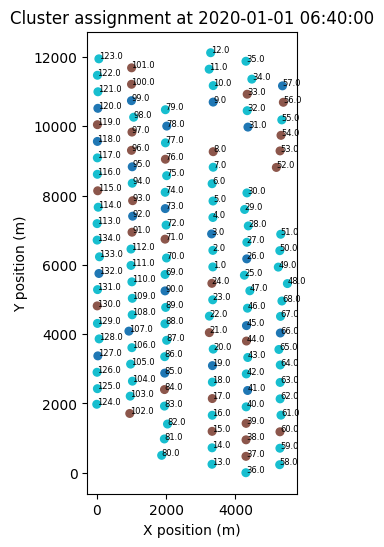

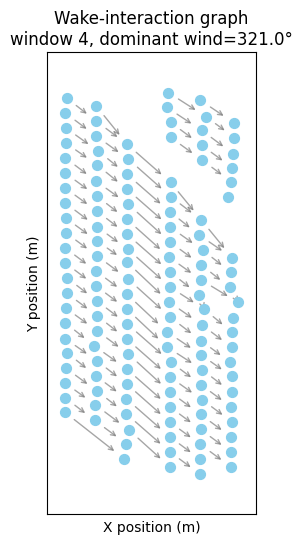

In [102]:
# 4. – Plot the RESULTS for one window of your choice
i = OUTPUT_TIMESTAMP
ts_window, labels2d = window_labels[i]

# Ensure labels match the number of turbines for plotting
# If labels2d is 2D and has more than one row, select the first row's N labels (N = number of turbines)
if labels2d.ndim == 2 and labels2d.shape[0] > 1:
    labels_single = labels2d[0][:len(pos_df)]
else:
    labels_single = labels2d[:len(pos_df)]

plot_clusters(pos_df, labels_single, ts_window[0])

# plot the corresponding graph
plot_graph(window_graphs[i], pos_df,
           f"Wake‐interaction graph\nwindow {i}, dominant wind={window_directions[i]:.1f}°")

In [84]:
print(wind_df.head())

        Day Tmstamp  Wspd  Wdir   Etmp   Itmp   Ndir  Pab1  Pab2  Pab3  Prtv  \
TurbID                                                                         
1         1   00:00   NaN  0.00    NaN    NaN   0.00   NaN   NaN   NaN   NaN   
1         1   00:10  6.17 -3.99  30.73  41.80  25.92   1.0   1.0   1.0 -0.25   
1         1   00:20  6.27 -2.18  30.60  41.63  20.91   1.0   1.0   1.0 -0.24   
1         1   00:30  6.42 -0.73  30.52  41.52  20.91   1.0   1.0   1.0 -0.26   
1         1   00:40  6.25  0.89  30.49  41.38  20.91   1.0   1.0   1.0 -0.23   

          Patv  AbsWdir  
TurbID                   
1          NaN     0.00  
1       494.66    21.93  
1       509.76    18.73  
1       542.53    20.18  
1       509.36    21.80  
